<a href="https://colab.research.google.com/github/ramisetti/3SDLMooringPrediction/blob/main/3SDL_Example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import math
import time
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as dl
import torch.nn.functional as F
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [ ]:
df = pd.read_csv("15MW_Semi_4.out", delimiter = '\t', skiprows = 5)
df.drop(0, inplace = True)
df = df.astype('float64')

col = ["PtfmSurge","PtfmSway","PtfmHeave","PtfmRoll","PtfmPitch","PtfmYaw","FAIRTEN1","FAIRTEN2","FAIRTEN3"]
X = df.loc[:,["PtfmSurge","PtfmSway","PtfmHeave","PtfmRoll","PtfmPitch","PtfmYaw","FAIRTEN1","FAIRTEN2","FAIRTEN3"]]
y = df.loc[:,["FAIRTEN1","FAIRTEN2","FAIRTEN3"]]


class TOtensor:
    def __call__(self, sample):
        inputs, targets = sample
        inputs = inputs.to_numpy()
        targets = targets.to_numpy()
        return torch.from_numpy(inputs).to(torch.float32), torch.from_numpy(targets).to(torch.float32)

class ABCD(Dataset):
    def __init__(self,data,transform = None):
        self.data = data
        self.n_samples = data.shape[0]-10
        self.x_data = data
        self.y_data = data
        self.transform = transform

    def __getitem__(self, index):
        self.index = int(index)
        sample= self.x_data.loc[index:index+4,:], self.y_data.loc[index+5,"FAIRTEN1":"FAIRTEN3"]
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return self.n_samples


from sklearn.preprocessing import MinMaxScaler

std_scaler = MinMaxScaler(feature_range=(-1, 1))
X_unscaled = X.loc[2001:30000,:]

X_scaled = std_scaler.fit_transform(X_unscaled)
X_scaled = pd.DataFrame(X_scaled, columns=col)
X_scaled = X_scaled.astype('float64')
final_df = ABCD(X_scaled, transform= TOtensor())

train_loader = DataLoader(dataset=final_df,
                          batch_size=8,
                          shuffle=False,
                          num_workers= 0)



temp = X.iloc[30001:40000,:].reset_index()
temp = temp.drop(temp.columns[0],axis = 1)
y_scaled = std_scaler.transform(temp)
y_scaled = pd.DataFrame(y_scaled, columns=col)
y_scaled = y_scaled.astype('float64')
final_df_test = ABCD(y_scaled, transform= TOtensor())

test_loader = DataLoader(dataset=final_df_test,
                          batch_size=8,
                          shuffle=False,
                          num_workers= 0)


# Overall Network Architecture

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 9
sequence_len = 5
hidden_size = 256
num_targets = 3
num_layers = 3
learning_rate = 0.0001
class My_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_targets):
        super(My_model, self).__init__()
        self.input_size = input_size
        self.num_targets = num_targets
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional = False)
        self.fcc = nn.Linear(hidden_size, num_targets)
        self.sft = nn.Tanh()


    def forward(self, x):
        h0 = torch.zeros(self.num_layers , x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers , x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x,(h0, c0))
        out = out[:,-1,:]
        out = self.sft(out)
        out = self.sft(self.fcc(out))
        return out

model = My_model(input_size, hidden_size,num_layers, num_targets).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)



# Training

In [ ]:
best_loss = 10000000000000000000
t_loss = []
te_loss = []
running_loss = 0.0
test_loss = 0.0
running_correct = 0
curr_sample = 0
n_epochs = 50
num_iter = math.ceil((final_df.n_samples) / train_loader.batch_size)
for epoch in range(n_epochs):
    running_loss = 0
    start_time = time.time()
    for i,(features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)
        features = features.reshape(-1, sequence_len, input_size)
        out = model(features)
        loss = criterion(out,targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    test_loss = 0

    target_1 = []
    target_2 = []
    target_3 = []
    pred_1 = []
    pred_2 = []
    pred_3 = []

    for (features, targets) in test_loader:
        with torch.no_grad():
            features = features.to(device)
            features = features.reshape(-1, sequence_len, input_size)
            targets = targets.to(device)
            out = model(features)
            loss = (criterion(out,targets))
            test_loss += loss.item()

            targets = targets.to('cpu').numpy()
            out = out.detach().to('cpu').numpy()
            pred_1.append(out[0][0])
            pred_2.append(out[0][1])
            pred_3.append(out[0][2])
            target_1.append(targets[0][0])
            target_2.append(targets[0][1])
            target_3.append(targets[0][2])

    epoch_loss = running_loss / (final_df.n_samples)
    epoch_test_loss = test_loss /(final_df_test.n_samples)
    total_secs = int(time.time() - start_time)


    if best_loss > epoch_test_loss:
      best_loss = epoch_test_loss
      best_model = deepcopy(model)

    t_loss.append(epoch_loss)
    te_loss.append(epoch_test_loss)
    print(f'Epoch {epoch+1}, Training loss {epoch_loss:.5f}, Testing Loss {epoch_test_loss:.5f}, Total time in Secs{total_secs}')

print(f'Best Model Loss, {best_loss}')



Epoch 1, Training loss 0.00274, Testing Loss 0.00179, Total time in Secs26
Epoch 2, Training loss 0.00061, Testing Loss 0.00087, Total time in Secs25
Epoch 3, Training loss 0.00037, Testing Loss 0.00054, Total time in Secs25
Epoch 4, Training loss 0.00031, Testing Loss 0.00029, Total time in Secs26
Epoch 5, Training loss 0.00022, Testing Loss 0.00020, Total time in Secs25
Epoch 6, Training loss 0.00015, Testing Loss 0.00017, Total time in Secs24
Epoch 7, Training loss 0.00012, Testing Loss 0.00014, Total time in Secs25
Epoch 8, Training loss 0.00010, Testing Loss 0.00012, Total time in Secs25
Epoch 9, Training loss 0.00008, Testing Loss 0.00011, Total time in Secs25
Epoch 10, Training loss 0.00008, Testing Loss 0.00009, Total time in Secs25
Epoch 11, Training loss 0.00007, Testing Loss 0.00009, Total time in Secs25
Epoch 12, Training loss 0.00007, Testing Loss 0.00008, Total time in Secs25
Epoch 13, Training loss 0.00006, Testing Loss 0.00008, Total time in Secs24
Epoch 14, Training lo

<function matplotlib.pyplot.show(close=None, block=None)>

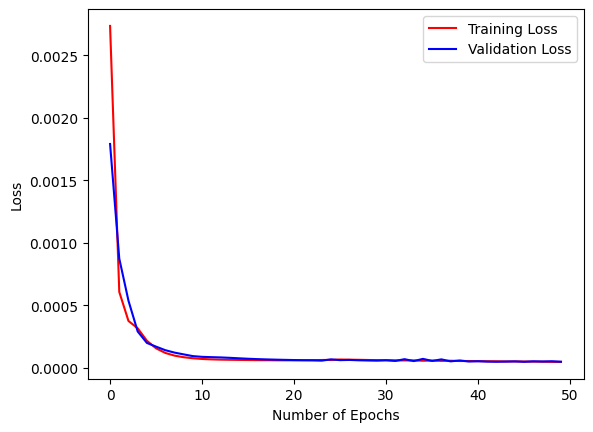

In [ ]:
plt.plot(np.array(t_loss), 'r', label = "Training Loss")
plt.plot(np.array(te_loss), 'b', label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.show

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 13.5 MB/s eta 0:00:00


In [ ]:
from torchmetrics import MeanSquaredLogError, MeanAbsolutePercentageError, MeanSquaredError
mean_squared_log_error = MeanSquaredLogError()
mean_abs_percentage_error = MeanAbsolutePercentageError()
mean_squared_error = MeanSquaredError()

# Testing/ Predictions

(92001, 204)
/content/drive/MyDrive/CSIR MAIN/CSIR Data/Copy of 15MW_Semi_12.out
89991


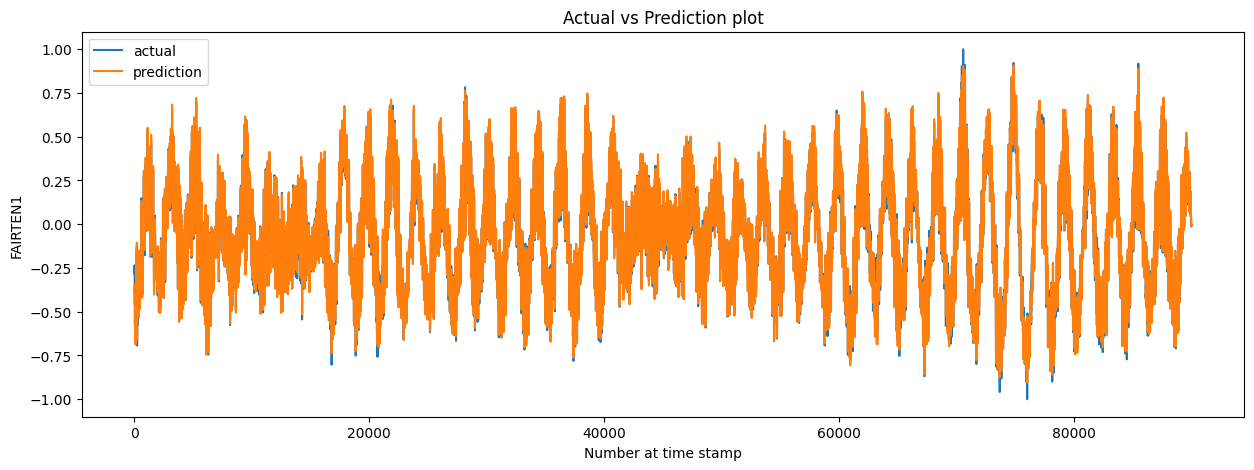

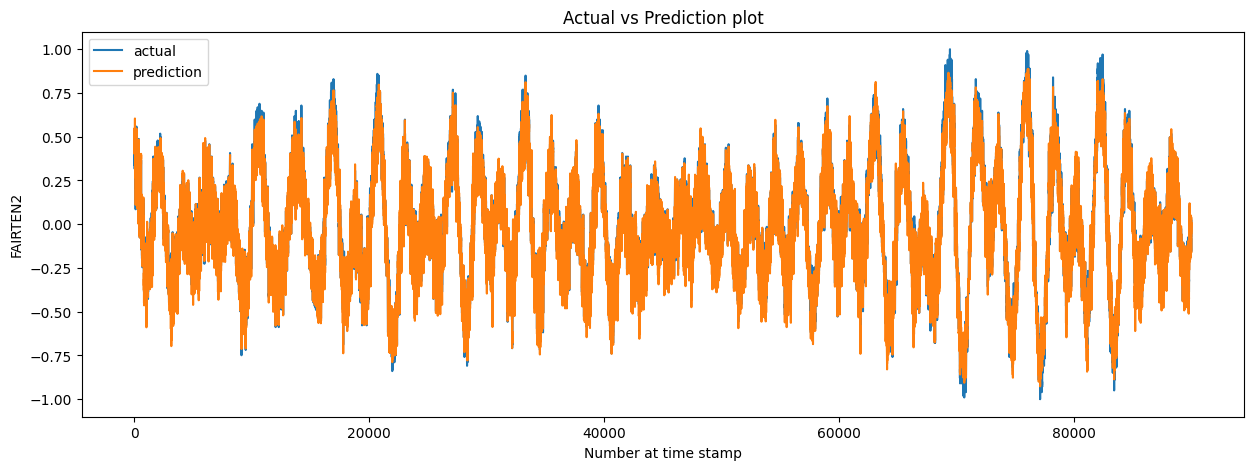

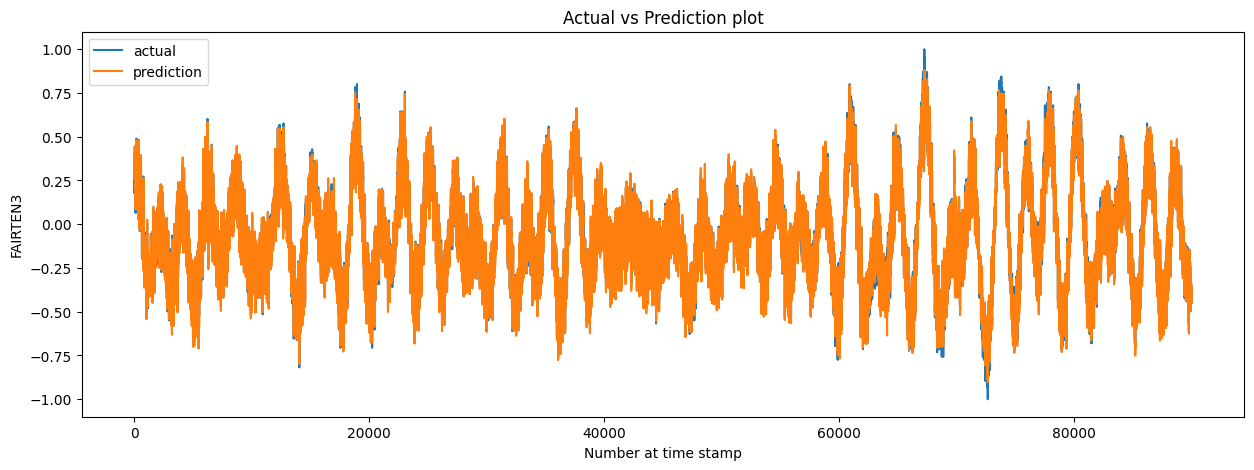

Results Scaled
Fairten1 0.9949547478565394
Fairten2 0.9877005139951777
Fairten3 0.991807540253203
MAPE SCore 1 tensor(0.0023)
MAPE SCore 2 tensor(0.0013)
MAPE SCore 3 tensor(0.0011)
MSE SCore 1 tensor(1.4355e+08)
MSE SCore 2 tensor(12532035.)
MSE SCore 3 tensor(8691039.)


In [ ]:
fair_1_res = []
fair_2_res = []
fair_3_res = []

mlse_1 = []
mlse_2 = []
mlse_3 = []

mape_1 = []
mape_2 = []
mape_3 = []

mse_1 = []
mse_2 = []
mse_3 = []
import os
import pandas as pd
import warnings
warnings.simplefilter('ignore')

folderpath = "Data"
filepaths = [os.path.join(folderpath, name) for name in os.listdir(folderpath)]
for path in filepaths:
  if path == "15MW_Semi_12.out":
    dx = pd.read_csv(path, delimiter = '\t', skiprows = 5)
    dx.drop(0, inplace = True)
    dx = dx.astype('float64')
    print(dx.shape)
    print(path)


    X = dx.loc[:,["PtfmSurge","PtfmSway","PtfmHeave","PtfmRoll","PtfmPitch","PtfmYaw","FAIRTEN1","FAIRTEN2","FAIRTEN3"]]
    y = dx.loc[:,["FAIRTEN1","FAIRTEN2","FAIRTEN3"]]

    col = ["PtfmSurge","PtfmSway","PtfmHeave","PtfmRoll","PtfmPitch","PtfmYaw","FAIRTEN1","FAIRTEN2","FAIRTEN3"]


    from sklearn.preprocessing import MinMaxScaler
    std_scaler_for_test = MinMaxScaler(feature_range=(-1, 1))


    X_unscaled = X.loc[2001:,:]
    X_scaled = std_scaler_for_test.fit_transform(X_unscaled)
    # X_scaled = std_scaler.transform(X_unscaled)
    X_scaled = pd.DataFrame(X_scaled, columns=col)
    X_scaled = X_scaled.astype('float64')


    final_df = ABCD(X_scaled, transform= TOtensor())

    def inverseify(initials, last = None, col = ["PtfmSurge","PtfmSway","PtfmHeave","PtfmRoll","PtfmPitch","PtfmYaw","FAIRTEN1","FAIRTEN2","FAIRTEN3"]):
      last = np.array(last)
      full = np.concatenate((initials, last), axis=1)
      X_rev = std_scaler_for_test.inverse_transform(full)
      X_rev = pd.DataFrame(X_rev, columns=col)
      X_rev = X_rev.astype('float64')
      return X_rev

    test_loader_new_dataset = DataLoader(dataset=final_df,
                              batch_size=8,
                              shuffle=False,
                              num_workers= 0)
    target_1 = []
    target_2 = []
    target_3 = []
    pred_1 = []
    pred_2 = []
    pred_3 = []
    feature_list = []
    i = 0
    for i,(features, targets) in enumerate(test_loader_new_dataset):
            with torch.no_grad():
                features = features.to(device)
                features = features.reshape(-1, sequence_len, input_size)
                targets = targets.to(device)
                out = best_model(features)

                features = features.to('cpu').numpy()
                targets = targets.to('cpu').numpy()
                out = out.detach().to('cpu').numpy()

                # print(features.shape)
                for j in range(features.shape[0]):
                  features_1 = features[j][0]
                  features_1 = features_1[:-3]
                  feature_list.append(features_1)



                for j in range(out.shape[0]):
                  pred_1.append(out[j][0])
                  pred_2.append(out[j][1])
                  pred_3.append(out[j][2])

                  target_1.append(targets[j][0])
                  target_2.append(targets[j][1])
                  target_3.append(targets[j][2])


    i = i+1

    print(len(target_1))


    plt.figure(figsize = (15,5))
    plt.plot(target_1)
    plt.plot(pred_1)
    # plt.plot(target_3)
    plt.title('Actual vs Prediction plot')
    plt.ylabel('FAIRTEN1')
    plt.xlabel('Number at time stamp')
    plt.legend(['actual', 'prediction'], loc='upper left')
    plt.show()
    plt.figure(figsize = (15,5))
    plt.plot(target_2)
    plt.plot(pred_2)
    # plt.plot(target_3)
    plt.title('Actual vs Prediction plot')
    plt.ylabel('FAIRTEN2')
    plt.xlabel('Number at time stamp')
    plt.legend(['actual', 'prediction'], loc='upper left')
    plt.show()
    plt.figure(figsize = (15,5))
    plt.plot(target_3)
    plt.plot(pred_3)
    # plt.plot(target_3)
    plt.title('Actual vs Prediction plot')
    plt.ylabel('FAIRTEN3')
    plt.xlabel('Number at time stamp')
    plt.legend(['actual', 'prediction'], loc='upper left')
    plt.show()



    target_1 = np.array(target_1).reshape((-1,1))
    target_2 = np.array(target_2).reshape((-1,1))
    target_3 = np.array(target_3).reshape((-1,1))
    pred_1 = np.array(pred_1).reshape((-1,1))
    pred_2 = np.array(pred_2).reshape((-1,1))
    pred_3 = np.array(pred_3).reshape((-1,1))
    feature_list = np.array(feature_list).reshape((-1,6))

    from sklearn import metrics
    print("Results Scaled")
    print("Fairten1",metrics.r2_score(target_1,pred_1))
    print("Fairten2",metrics.r2_score(target_2,pred_2))
    print("Fairten3",metrics.r2_score(target_3,pred_3))


    fair_1_res.append(metrics.r2_score(target_1,pred_1))
    fair_2_res.append(metrics.r2_score(target_2,pred_2))
    fair_3_res.append(metrics.r2_score(target_3,pred_3))

    t = np.concatenate((target_1, target_2, target_3),axis = 1)
    unscaled_data_target = inverseify(feature_list,t)

    q = np.concatenate((pred_1, pred_2,pred_3),axis = 1)
    unscaled_data_pred = inverseify(feature_list,q)

    temp1 = mean_squared_log_error(torch.from_numpy(unscaled_data_target.iloc[:,-3].to_numpy()), torch.from_numpy(unscaled_data_pred.iloc[:,-3].to_numpy()))
    temp2 =mean_squared_log_error(torch.from_numpy(unscaled_data_target.iloc[:,-2].to_numpy()), torch.from_numpy(unscaled_data_pred.iloc[:,-2].to_numpy()))
    temp3 = mean_squared_log_error(torch.from_numpy(unscaled_data_target.iloc[:,-1].to_numpy()), torch.from_numpy(unscaled_data_pred.iloc[:,-1].to_numpy()))

    mlse_1.append(temp1)
    mlse_2.append(temp2)
    mlse_3.append(temp3)

    # print("MLSE SCore 1",temp1)
    # print("MLSE SCore 2",temp2)
    # print("MLSE SCore 3",temp3)

    temp1 = mean_abs_percentage_error(torch.from_numpy(unscaled_data_target.iloc[:,-3].to_numpy()), torch.from_numpy(unscaled_data_pred.iloc[:,-3].to_numpy()))
    temp2 =mean_abs_percentage_error(torch.from_numpy(unscaled_data_target.iloc[:,-2].to_numpy()), torch.from_numpy(unscaled_data_pred.iloc[:,-2].to_numpy()))
    temp3 = mean_abs_percentage_error(torch.from_numpy(unscaled_data_target.iloc[:,-1].to_numpy()), torch.from_numpy(unscaled_data_pred.iloc[:,-1].to_numpy()))

    mape_1.append(temp1)
    mape_2.append(temp2)
    mape_3.append(temp3)
    print("MAPE SCore 1",temp1)
    print("MAPE SCore 2",temp2)
    print("MAPE SCore 3",temp3)

    temp1 = mean_squared_error(torch.from_numpy(unscaled_data_target.iloc[:,-3].to_numpy()), torch.from_numpy(unscaled_data_pred.iloc[:,-3].to_numpy()))
    temp2 =mean_squared_error(torch.from_numpy(unscaled_data_target.iloc[:,-2].to_numpy()), torch.from_numpy(unscaled_data_pred.iloc[:,-2].to_numpy()))
    temp3 = mean_squared_error(torch.from_numpy(unscaled_data_target.iloc[:,-1].to_numpy()), torch.from_numpy(unscaled_data_pred.iloc[:,-1].to_numpy()))


    mse_1.append(temp1)
    mse_2.append(temp2)
    mse_3.append(temp3)
    print("MSE SCore 1",temp1)
    print("MSE SCore 2",temp2)
    print("MSE SCore 3",temp3)


